# 🚀 Reto de Ingeniería de Datos: Optimización y Visualización
**Diplomado en Estrategias de Datos - USTA**
* **Estudiante:** Victor Diaz
* **Fecha:** 03/01/2026

**Descripción:** En este cuaderno aplico técnicas de *downcasting*, vectorización y visualización avanzada sobre el dataset de Taxis de NYC (1.4M registros).


Iniciaremos con el cargue de las librerias y la configuracion de los graficos:


In [1]:
!pip install fpdf

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fpdf import FPDF
from pathlib import Path

# Configuración para que los gráficos se vean bien en retina display
%config InlineBackend.figure_format = 'retina'
sns.set_theme(style="whitegrid")

# Ocultar advertencias molestas (opcional)
import warnings
warnings.filterwarnings('ignore')

**Carga y Diagnóstico para saber la RAM esta consumiendo**

In [3]:
# Cargue de los datos
ruta_datos = Path("..")/ "app" / "data" / "train.csv"
df = pd.read_csv(ruta_datos, low_memory="False")
df.memory_usage(deep="True")

Index                       132
id                     96270504
vendor_id              11669152
pickup_datetime       110856944
dropoff_datetime      110856944
passenger_count        11669152
pickup_longitude       11669152
pickup_latitude        11669152
dropoff_longitude      11669152
dropoff_latitude       11669152
store_and_fwd_flag     84601352
trip_duration          11669152
dtype: int64

In [4]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 461.8 MB


El DataFrame ocupa 462 MB de RAM, principalmente por columnas tipo object (pickup_datetime, dropoff_datetime, id y store_and_fwd_flag), que superan ampliamente a las numéricas. Esto se debe a que pandas almacena referencias individuales en memoria. Convertir fechas, categorías y enteros reduciría el uso de RAM y mejoraría eficiencia y estabilidad del análisis.

**Optimización (Pandas Pro)**

In [5]:
df['vendor_id'] = pd.to_numeric(df['vendor_id'], downcast='integer')
df['passenger_count'] = pd.to_numeric(df['passenger_count'], downcast='integer')
df['trip_duration'] = pd.to_numeric(df['trip_duration'], downcast='integer')
df['pickup_longitude'] = pd.to_numeric(df['pickup_longitude'], downcast='float')
df['pickup_latitude'] = pd.to_numeric(df['pickup_latitude'], downcast='float')
df['dropoff_longitude'] = pd.to_numeric(df['dropoff_longitude'], downcast='float')
df['dropoff_latitude'] = pd.to_numeric(df['dropoff_latitude'], downcast='float')
df['store_and_fwd_flag'] = df['store_and_fwd_flag'].astype('category')
df.info(memory_usage='deep')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype   
---  ------              --------------    -----   
 0   id                  1458644 non-null  object  
 1   vendor_id           1458644 non-null  int8    
 2   pickup_datetime     1458644 non-null  object  
 3   dropoff_datetime    1458644 non-null  object  
 4   passenger_count     1458644 non-null  int8    
 5   pickup_longitude    1458644 non-null  float32 
 6   pickup_latitude     1458644 non-null  float32 
 7   dropoff_longitude   1458644 non-null  float32 
 8   dropoff_latitude    1458644 non-null  float32 
 9   store_and_fwd_flag  1458644 non-null  category
 10  trip_duration       1458644 non-null  int32   
dtypes: category(1), float32(4), int32(1), int8(2), object(3)
memory usage: 335.2 MB


### **Antes:** 461.8 MB 

### **Despues:** 335.2 MB.

# **Ingeniería de Variables**

- Cálculos vectorizados de fechas (dt.hour) y distancias (Haversine).
- Uso de .query()y .assign().

In [6]:
import time

# SIN especificar formato
sinf = time.time()
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'])
sinf1 = time.time()

# CON formato explícito
conf = time.time()
df['pickup_datetime'] = pd.to_datetime(
    df['pickup_datetime'],
    format='%Y-%m-%d %H:%M:%S'
)

df['dropoff_datetime'] = pd.to_datetime(
    df['dropoff_datetime'],
    format='%Y-%m-%d %H:%M:%S'
)
conf1 = time.time()

print(f"Sin formato {sinf1 - sinf:.2f} segundos se tardo y con formato {conf1 - conf:.2f} segundos se tardo") 

Sin formato 0.34 segundos se tardo y con formato 0.05 segundos se tardo


### **# Extraer componentes de fecha y Hora pico (más viajes iniciados)**

In [7]:
df['hour_of_day'] = df['pickup_datetime'].dt.hour
df['day_of_week'] = df['pickup_datetime'].dt.day_name()
# Hora pico
hora_pico = df['hour_of_day'].value_counts().idxmax()
hora_pico


np.int32(18)

La hora pico en donde se realizan mas viajes son a las 18 horas o 6 de la tarde 

**Fórmula de Haversine**

In [8]:
R = 6371  # Radio de la tierra
lat = np.radians(df['pickup_latitude'])
lon = np.radians(df['pickup_longitude'])
lat1 = np.radians(df['dropoff_latitude'])
lon1 = np.radians(df['dropoff_longitude'])
dlat = lat1 - lat
dlon = lon1 - lon
a = np.sin(dlat / 2)**2 + np.cos(lat) * np.cos(lat1) * np.sin(dlon / 2)**2
c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
df['distancia_km'] = R * c
df['distancia_km'].mean()

np.float32(3.4408643)

3.44 kilometros representa la distancia promedio entre los puntos de inicio y final del recorrido

**.query()**: Permite filtrar datos usando expresiones tipo texto, lo que mejora la legibilidad frente al boolean indexing tradicional.

In [9]:
df_f = df.query(
    "passenger_count > 1 and distancia_km > 0 and distancia_km < 100"
)
print(f"Número de viajes que cumplen: {df_f.shape[0]}")

Número de viajes que cumplen: 423345


**.assign()**: Permite crear nuevas columnas de forma dinámica dentro de una cadena de operaciones, manteniendo un flujo de código claro y legible

In [10]:
df_f.assign(
        vel_kph=lambda x: x['distancia_km'] / (x['trip_duration'] / 3600)
    ).sort_values('vel_kph', ascending=False)
df_f.head(5)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,hour_of_day,day_of_week,distancia_km
5,id0801584,2,2016-01-30 22:01:40,2016-01-30 22:09:03,6,-73.982857,40.742195,-73.992081,40.749184,N,443,22,Saturday,1.099062
6,id1813257,1,2016-06-17 22:34:59,2016-06-17 22:40:40,4,-73.969017,40.757839,-73.957405,40.765896,N,341,22,Friday,1.326208
11,id1299289,2,2016-05-15 11:16:11,2016-05-15 11:34:59,4,-73.991531,40.749439,-73.956543,40.770630,N,1128,11,Sunday,3.772823
12,id1187965,2,2016-02-19 09:52:46,2016-02-19 10:11:20,2,-73.962982,40.756680,-73.984406,40.760719,N,1114,9,Friday,1.859175
32,id3075902,2,2016-05-10 19:27:38,2016-05-10 19:44:40,2,-74.005501,40.706589,-73.985817,40.744202,N,1022,19,Tuesday,4.499405


## **Visualización Avanzada:**

 - Outliers (.clip) para controlar los datos atipos en los graficos

In [11]:
df["trip_outliers"] = df["trip_duration"].clip(
    lower=60,
    upper=7200 # 
)
print("Finalizado")

Finalizado


+ **Histogramas logarítmicos**

In [12]:
import os
from fpdf import FPDF
os.makedirs("imagenes", exist_ok=True)

def hist_log(df):
    plt.figure(figsize=(10, 5))
    sns.histplot(data=df, x='trip_outliers')
    plt.xscale('log')
    plt.title("Los viajes llegan en su mayoria a ser cortos")
    plt.xlabel("Duración del viaje en escala logaritmica")
    plt.ylabel("Frec.")
    plt.savefig("imagenes/hist_log.png", dpi=300, bbox_inches="tight")
    plt.close()

La escala logarítmica atenúa el efecto de los valores extremos, permitiendo observar la verdadera estructura de la distribución. Muestra que la mayoría de los viajes son cortos, mientras que los viajes largos, aunque poco frecuentes, distorsionan la visualización.

- **Análisis Geoespacial grafico de dispersión con Alpha**

In [13]:
def grafico_alpha(df):
    plt.figure(figsize=(6, 6))
    plt.scatter(
    df["distancia_km"],
    df["trip_outliers"],
    s=2,
    alpha=0.05
    )
    plt.xlim(0, 60)
    plt.title("Distancia–Duración")
    plt.xlabel("Distancia del viaje (km)")
    plt.ylabel("Duración del viaje")  
    plt.savefig("imagenes/grafico_alpha.png", dpi=300, bbox_inches="tight")
    plt.close()


Se reduce el efecto de los valores extremos sin eliminar datos, esto permite ver claramente la relación positiva entre distancia y duración. La mayoría de los viajes son cortos, mientras que algunos muy largos se “toparon” en 7200 segundos para no distorsionar la escala.

- **Análisis Geoespacial grafico de dispersión con Hexbins**

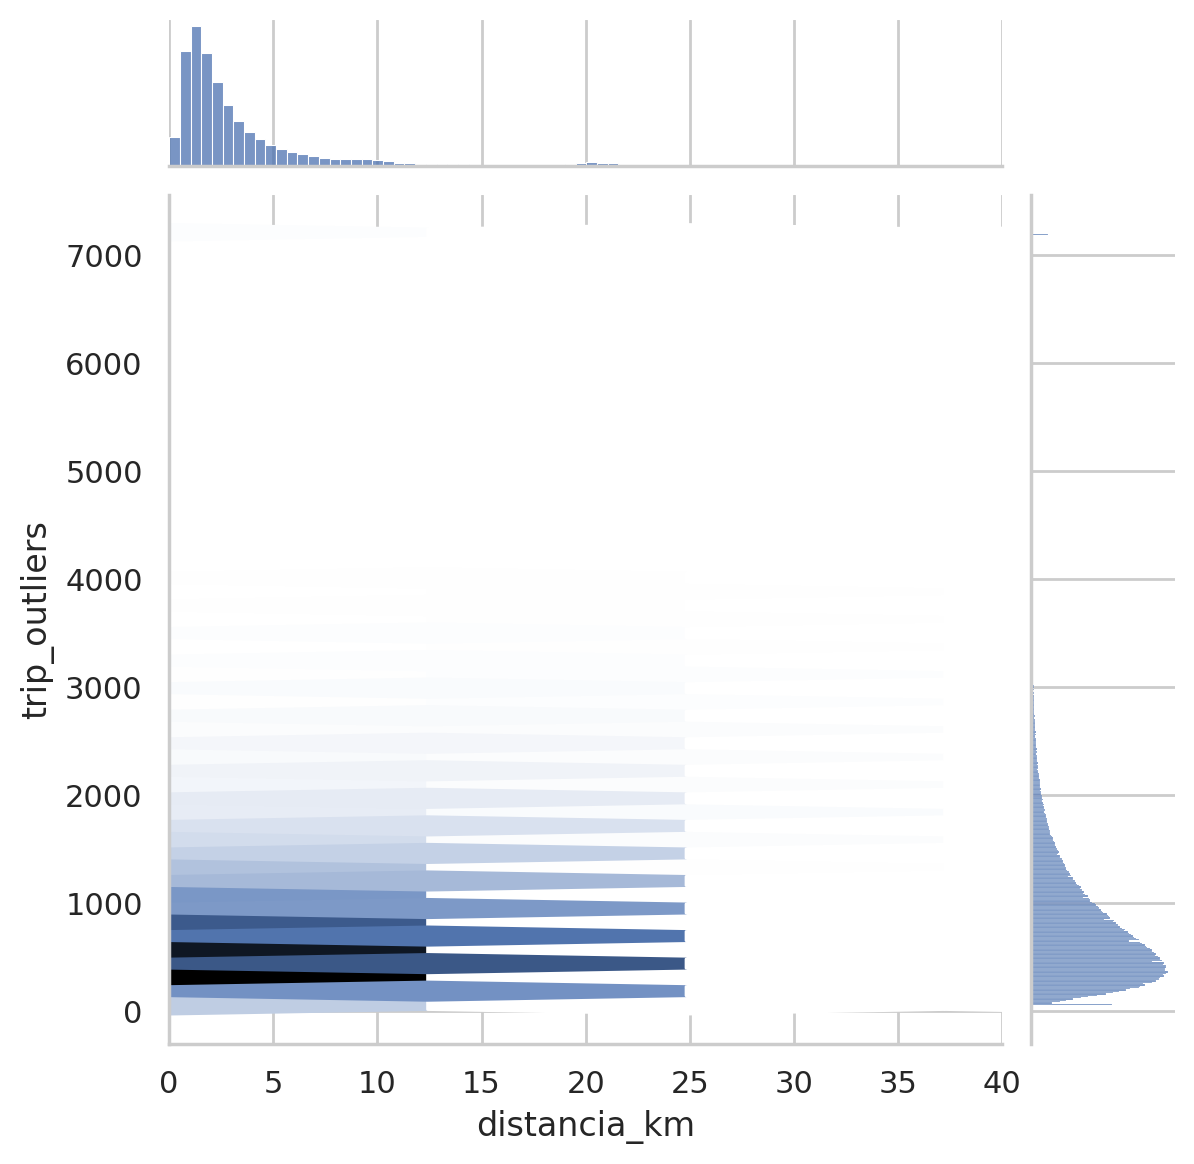

In [14]:
sns.jointplot(
    data=df,
    x="distancia_km",
    y="trip_outliers",
    kind="hex",
    xlim=(0,40)
)
plt.show()


El gráfico hexagonal permite visualizar la densidad de viajes, revelando con claridad las zonas donde se concentra la mayor actividad

- **Heatmaps de Día vs Hora**

In [15]:
def heatmap(df):
    tabla_pivote = df.pivot_table(
        index="day_of_week",
        columns="hour_of_day",
        values="trip_outliers",
        aggfunc="count"
    )

    plt.figure(figsize=(12, 6))
    sns.heatmap(
        tabla_pivote,
        cmap="Greens",      # Tonos verdes
        linewidths=0.5,    # Líneas divisorias
        linecolor='white'
    )
    plt.title("Día vs Hora")
    plt.xlabel("Hora")
    plt.ylabel("Día de la Semana")
    plt.savefig("imagenes/heatmap.png", dpi=300, bbox_inches="tight")
    plt.close()


El rango de mayor congestión ocurre los viernes entre las 18:00 y 21:00, con un pico máximo alrededor de las 19:00 y de las 21:00 horas, son actividades propias del inicio del fin de semana.

**Reporte Automatizado (Capstone)**

In [16]:
def reporte(df):

    # Generar assets
    hist_log(df)
    grafico_alpha(df)
    heatmap(df)

    pdf = FPDF()
    pdf.add_page()

    # Tipo de letra
    pdf.set_font("Arial", "B", 16)
    pdf.cell(0, 10, "Reporte Automatizado de Movilidad de los Taxis en NY", ln=True, align="C")
    pdf.ln(5)

    
    # Texto dinámico
    ram_inicial = 461.8
    ram_final = 335.2
    reduccion = ram_inicial - ram_final
    reduccion = (reduccion / ram_inicial) * 100

    hora_pico = df["hour_of_day"].value_counts().idxmax()
    total_viajes = df.shape[0]

    pdf.set_font("Arial", "B", 14)
    pdf.cell(0, 10, "Conclusiones", ln=True)
    pdf.ln(3)

    pdf.set_font("Arial", size=11)

    pdf.multi_cell(
    0,
    8,
    f"1. Optimización de memoria:\n"
    f"   Tras convertir columnas numéricas a tipos más eficientes y transformar variables categóricas, "
    f"el tamaño del dataset de viajes en taxi se redujo de {ram_inicial:.1f} MB a {ram_final:.1f} MB, "
    f"lo que representa una disminución aproximada del {reduccion:.1f}% sin pérdida de información.\n\n"

    f"2. Patrones de movilidad:\n"
    f"   El análisis temporal de los viajes mostró que la mayor actividad ocurre en la tarde, con hora pico "
    f"a las {hora_pico}:00. Los viernes se observa una congestión más prolongada entre las 18:00 y 21:00, "
    f"probablemente asociada al cierre laboral y a actividades sociales.\n\n"

    f"3. Eficiencia técnica:\n"
    f"   La aplicación de operaciones vectorizadas y la conversión explícita de fechas aceleraron el procesamiento "
    f"del dataset, logrando mejoras de hasta 28 segundos en comparación con métodos no optimizados."
)


    pdf.ln(5)

    # Cargue de Imagenes
    pdf.image("imagenes/hist_log.png", w=180)
    pdf.ln(5)

    pdf.image("imagenes/grafico_alpha.png", w=180)
    pdf.ln(5)

    pdf.image("imagenes/heatmap.png", w=180)
    pdf.ln(5)

    pdf.output("Resultados.pdf")

reporte(df)